# Experiment 2 - Encoder capacity benefits
This is a cleaned notebook responsible to analyze the results obtained by running experiment 2. It loads the data, prints important statistics, and creates the plots.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('results/experiment2_same_decoders/experiment2_results.csv')

In [2]:
# general gap statistics
std_data = df[df['model'] == 'standard']
large_data = df[df['model'] == 'large']

print("\namort gap:")
print(f"  small encoder: {std_data['G_amor'].mean():.4f} ± {std_data['G_amor'].std():.4f}")
print(f"                    median: {std_data['G_amor'].median():.4f}, IQR: [{std_data['G_amor'].quantile(0.25):.4f}, {std_data['G_amor'].quantile(0.75):.4f}]")
print(f"                    min: {std_data['G_amor'].min():.4f}, max: {std_data['G_amor'].max():.4f}")

print(f"\n  large encdoer:    {large_data['G_amor'].mean():.4f} ± {large_data['G_amor'].std():.4f}")
print(f"                    median: {large_data['G_amor'].median():.4f}, IQR: [{large_data['G_amor'].quantile(0.25):.4f}, {large_data['G_amor'].quantile(0.75):.4f}]")
print(f"                    min: {large_data['G_amor'].min():.4f}, max: {large_data['G_amor'].max():.4f}")

abs_improvement = std_data['G_amor'].values - large_data['G_amor'].values
print(f"\n  abs improvment: {abs_improvement.mean():.4f} ± {abs_improvement.std():.4f} nats")
print(f"                        median: {np.median(abs_improvement):.4f}, IQR: [{np.percentile(abs_improvement, 25):.4f}, {np.percentile(abs_improvement, 75):.4f}]")

rel_improvement = (std_data['G_amor'].values - large_data['G_amor'].values) / std_data['G_amor'].values * 100
print(f"\n  rel improvement: {np.mean(rel_improvement):.2f}% ± {np.std(rel_improvement):.2f}%")
print(f"                        median: {np.median(rel_improvement):.2f}%, IQR: [{np.percentile(rel_improvement, 25):.2f}%, {np.percentile(rel_improvement, 75):.2f}%]")
print(f"                        min: {np.min(rel_improvement):.2f}%, max: {np.max(rel_improvement):.2f}%")

n_improved = np.sum(abs_improvement > 0)
n_worsened = np.sum(abs_improvement < 0)
n_unchanged = np.sum(abs_improvement == 0)
print(f"\n  # better:  {n_improved}/1000 ({n_improved/10:.1f}%)")
print(f"  # worse:  {n_worsened}/1000 ({n_worsened/10:.1f}%)")

cohens_d = (std_data['G_amor'].mean() - large_data['G_amor'].mean()) / np.sqrt((std_data['G_amor'].std()**2 + large_data['G_amor'].std()**2) / 2)
print(f"\n  Cohen's d (effect size): {cohens_d:.4f}")

t_stat, p_value = stats.ttest_rel(std_data['G_amor'].values, large_data['G_amor'].values) # paired t-test
print(f"  Paired t-test: t={t_stat:.4f}, p={p_value:.2e}")

print(f"\n\napprox gap: {std_data['G_app'].mean():.4f}, {large_data['G_app'].mean():.4f}") # should be identical


amort gap:
  small encoder: 1.7482 ± 1.5881
                    median: 1.4159, IQR: [0.9093, 2.2114]
                    min: 0.1188, max: 35.6644

  large encdoer:    1.2329 ± 0.8515
                    median: 1.1021, IQR: [0.7673, 1.5571]
                    min: 0.1493, max: 19.4274

  abs improvment: 0.5152 ± 1.0242 nats
                        median: 0.2956, IQR: [-0.0322, 0.8269]

  rel improvement: 13.86% ± 44.52%
                        median: 22.74%, IQR: [-3.12%, 43.73%]
                        min: -285.76%, max: 87.43%

  # better:  733/1000 (73.3%)
  # worse:  267/1000 (26.7%)

  Cohen's d (effect size): 0.4044
  Paired t-test: t=15.9002, p=6.45e-51


approx gap: 1.2663, 1.2663


In [3]:
digit_stats = []
for digit in range(10):
    std_digit = std_data[std_data['digit_label'] == digit]['G_amor'].values
    large_digit = large_data[large_data['digit_label'] == digit]['G_amor'].values
    
    abs_imp = std_digit - large_digit
    rel_imp = (std_digit - large_digit) / std_digit * 100
    
    digit_stats.append({
        'Digit': digit,
        'Std_mean': std_digit.mean(),
        'Std_std': std_digit.std(),
        'Std_median': np.median(std_digit),
        'Large_mean': large_digit.mean(),
        'Large_std': large_digit.std(),
        'Large_median': np.median(large_digit),
        'Abs_imp_mean': abs_imp.mean(),
        'Abs_imp_std': abs_imp.std(),
        'Rel_imp_mean': rel_imp.mean(),
        'Rel_imp_std': rel_imp.std(),
        'Rel_imp_median': np.median(rel_imp),
        'N_improved': np.sum(abs_imp > 0),
        'N_worsened': np.sum(abs_imp < 0),
        'Pct_improved': np.sum(abs_imp > 0),
        'Pct_worsened': np.sum(abs_imp < 0),
        'Cohens_d': (std_digit.mean() - large_digit.mean()) / np.sqrt((std_digit.std()**2 + large_digit.std()**2) / 2),
        't_stat': stats.ttest_rel(std_digit, large_digit)[0],
        'p_value': stats.ttest_rel(std_digit, large_digit)[1]
    })

digit_stats_df = pd.DataFrame(digit_stats)
digit_stats_df

,Digit,Std_mean,Std_std,Std_median,Large_mean,Large_std,Large_median,Abs_imp_mean,Abs_imp_std,Rel_imp_mean,Rel_imp_std,Rel_imp_median,N_improved,N_worsened,Pct_improved,Pct_worsened,Cohens_d,t_stat,p_value
0,0,1.757204,1.233041,1.350571,1.194464,0.566893,1.029598,0.562740,0.912490,18.006721,39.628062,24.296758,78,22,78,22,0.586417,6.136168,1.750399e-08
1,1,0.804104,0.819844,0.513544,0.633599,0.537744,0.478283,0.170506,0.437328,0.878262,49.972141,10.645192,60,40,60,40,0.245936,3.879265,1.888073e-04
2,2,2.513523,1.097897,2.303837,1.414713,0.493687,1.392048,1.098810,1.061312,35.770018,28.407678,40.056955,90,10,90,10,1.290885,10.301418,2.408995e-17
3,3,1.847389,0.951839,1.597233,1.358841,0.531555,1.336788,0.488548,0.721170,14.674360,40.593158,22.012871,73,27,73,27,0.633744,6.740420,1.060881e-09
4,4,1.917098,1.047639,1.683735,1.571088,0.622964,1.472340,0.346009,0.977218,3.851879,50.342225,9.967792,64,36,64,36,0.401465,3.523012,6.473155e-04
5,5,2.396022,3.477157,1.933247,1.591363,1.884332,1.286972,0.804659,1.738988,24.919604,29.504129,30.684198,81,19,81,19,0.287733,4.603973,1.232891e-05
6,6,1.569728,0.954192,1.272602,1.187598,0.559629,1.035805,0.382130,0.743019,9.384745,47.568313,17.825965,70,30,70,30,0.488533,5.117153,1.523526e-06
7,7,1.471313,0.921577,1.232857,1.109098,0.609972,0.914333,0.362214,0.694819,11.578503,54.044572,23.926485,80,20,80,20,0.463508,5.186946,1.136159e-06
8,8,1.863606,1.308519,1.388550,1.167214,0.527713,1.055187,0.696392,1.034724,25.474627,32.788344,32.512755,80,20,80,20,0.698016,6.696482,1.304849e-09
9,9,1.341719,1.417817,0.897011,1.101375,0.716085,0.908211,0.240343,1.005357,-5.965709,46.862916,5.756691,57,43,57,43,0.213988,2.378643,1.929499e-02


In [4]:
# Between-digit vs within-digit variance
all_abs_imp = abs_improvement

total_var = np.var(all_abs_imp)
between_digit_var = np.var([digit_stats_df[digit_stats_df['Digit'] == d]['Abs_imp_mean'].values[0] for d in range(10)])
within_digit_var = np.mean([np.var(std_data[std_data['digit_label'] == d]['G_amor'].values - large_data[large_data['digit_label'] == d]['G_amor'].values) for d in range(10)])

total_var, between_digit_var/total_var, within_digit_var/total_var

(np.float64(1.0489930256064801),
 np.float64(0.06904585148507907),
 np.float64(0.9309541485149212))

In [5]:
all_std_gamor = std_data['G_amor'].values
all_rel_imp = rel_improvement

improvement_sorted = pd.DataFrame({
    'datapoint_idx': std_data['datapoint_idx'].values,
    'digit': std_data['digit_label'].values,
    'std_gamor': all_std_gamor,
    'large_gamor': large_data['G_amor'].values,
    'abs_imp': all_abs_imp,
    'rel_imp': all_rel_imp
}).sort_values('abs_imp', ascending=False)

improvement_sorted

,datapoint_idx,digit,std_gamor,large_gamor,abs_imp,rel_imp
569,775,5,35.664368,19.427368,16.237000,45.527232
972,704,9,9.041550,1.770081,7.271469,80.422819
830,404,8,7.762192,2.310028,5.452164,70.240003
822,312,8,7.653625,2.738060,4.915565,64.225320
459,605,4,7.022522,2.113136,4.909386,69.909154
...,...,...,...,...,...,...
744,426,7,0.765633,2.267982,-1.502350,-196.223332
769,640,7,1.856804,3.518211,-1.661407,-89.476733
478,749,4,0.648766,2.382072,-1.733307,-267.169989
473,717,4,1.177505,2.932907,-1.755402,-149.077998


/var/folders/92/yglwvnmx2bsg0b42jym1s8lh0000gn/T/ipykernel_70310/2664009269.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data,


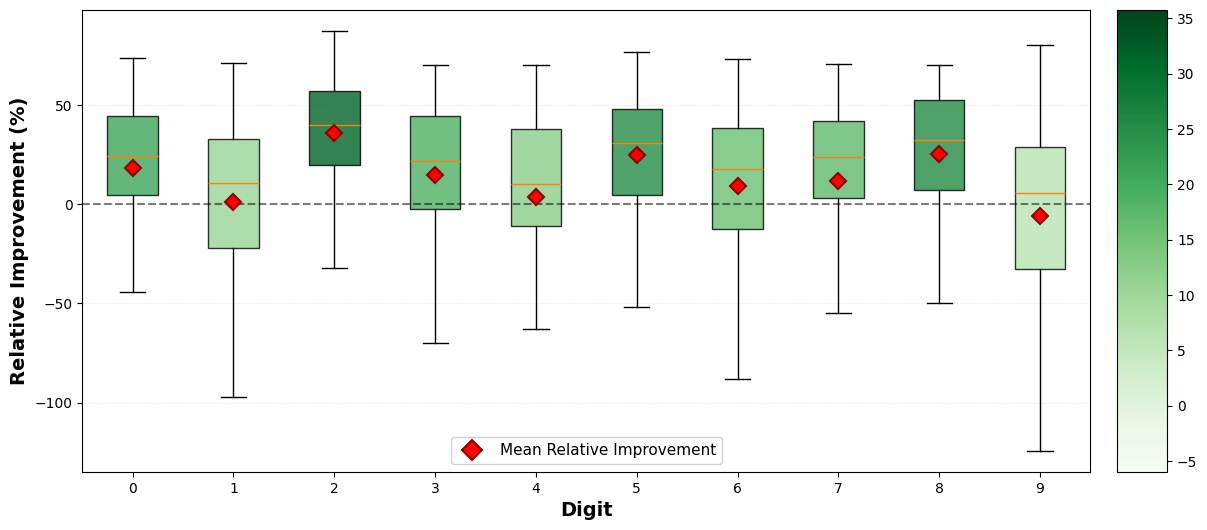

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('results/experiment2_same_decoders/experiment2_results.csv')

boxplot_data = []
for digit in range(10):
    digit_data = df[df['digit_label'] == digit]
    std = digit_data[digit_data['model'] == 'standard']['G_amor'].values
    large = digit_data[digit_data['model'] == 'large']['G_amor'].values
    
    rel_imp = (std - large) / std * 100
    boxplot_data.append(rel_imp)

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[20, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

bp = ax.boxplot(boxplot_data, 
                labels=[str(i) for i in range(10)],
                patch_artist=True,
                showmeans=True,
                showfliers=False,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8, 
                             markeredgecolor='darkred', markeredgewidth=1.5))

# single color colorbar because of Simons feedback
mean_improvements = [np.mean(data) for data in boxplot_data]
min_mean = min(mean_improvements)
max_mean = max(mean_improvements)
normalized_means = [(m - min_mean) / (max_mean - min_mean) for m in mean_improvements]
colors = plt.cm.Greens(np.array(normalized_means) * 0.6 + 0.3) 

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel('Digit', fontsize=14, fontweight='bold')
ax.set_ylabel('Relative Improvement (%)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.8)

legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', label='Mean Relative Improvement',
              markerfacecolor='red', markersize=10, markeredgecolor='darkred', markeredgewidth=1.5),
]
ax.legend(handles=legend_elements, loc='lower center', fontsize=11, framealpha=0.9)

cmap = plt.cm.Greens
norm = plt.cm.colors.Normalize(vmin=min_mean, vmax=max_mean)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)

plt.savefig('figures/exp2_boxplot_improvement.pdf', bbox_inches='tight', dpi=300)
plt.show()

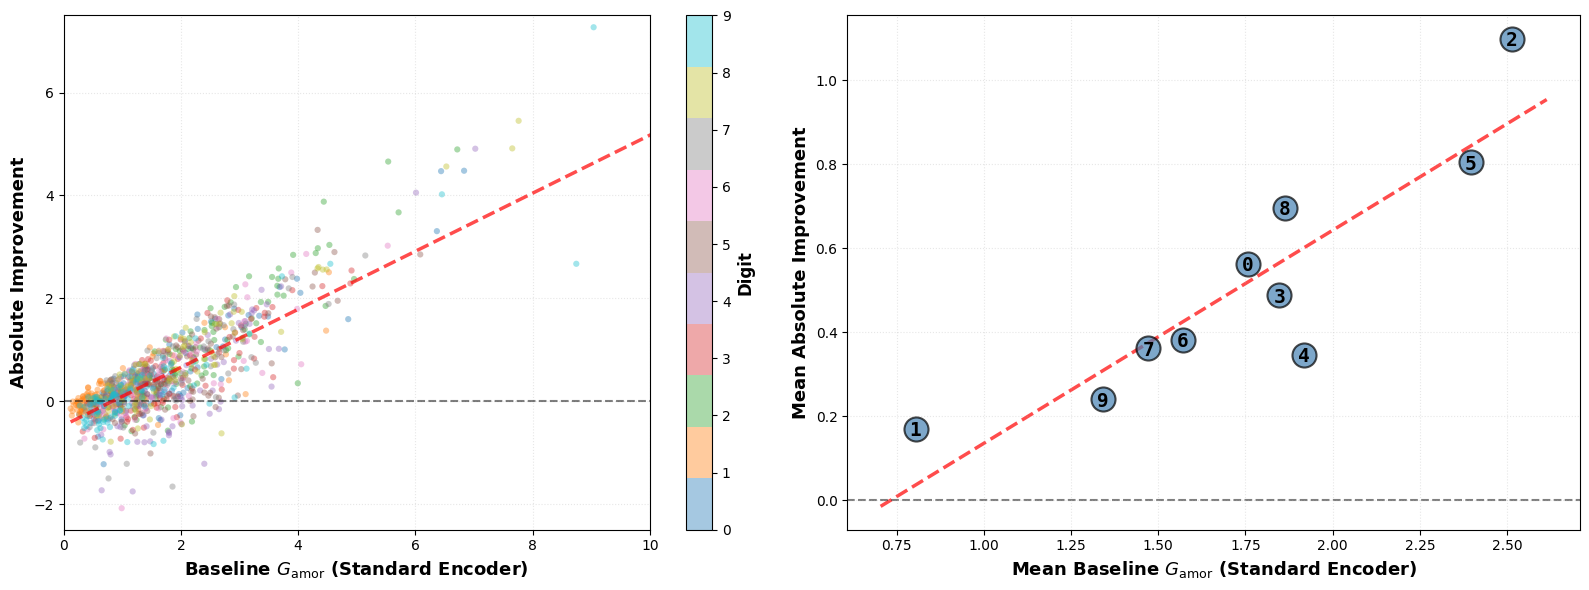

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('results/experiment2_same_decoders/experiment2_results.csv')

all_std = []
all_imp = []
all_digits = []
for digit in range(10):
    digit_data = df[df['digit_label'] == digit]
    std = digit_data[digit_data['model'] == 'standard']['G_amor'].values
    large = digit_data[digit_data['model'] == 'large']['G_amor'].values
    
    improvement = std - large
    
    all_std.extend(std)
    all_imp.extend(improvement)
    all_digits.extend([digit]*len(std))

all_std = np.array(all_std)
all_imp = np.array(all_imp)
all_digits = np.array(all_digits)

pearson_datapoint, p_datapoint = stats.pearsonr(all_std, all_imp)

results = []
for digit in range(10):
    digit_data = df[df['digit_label'] == digit]
    std_data = digit_data[digit_data['model'] == 'standard']
    large_data = digit_data[digit_data['model'] == 'large']
    
    baseline_gamor = std_data['G_amor'].mean()
    abs_improvement = (std_data['G_amor'].values - large_data['G_amor'].values).mean()
    
    results.append({
        'Digit': digit,
        'Baseline G_amor': baseline_gamor,
        'Abs. Improvement': abs_improvement
    })

results_df = pd.DataFrame(results)
baseline_vals = results_df['Baseline G_amor'].values
abs_imp_vals = results_df['Abs. Improvement'].values

pearson_digit, p_digit = stats.pearsonr(baseline_vals, abs_imp_vals)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# left scatter plot
scatter = axes[0].scatter(all_std, all_imp, c=all_digits, cmap='tab10', 
                         alpha=0.4, s=20, edgecolors='none')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# linear fit (but not sure if i should actually keep it)
z = np.polyfit(all_std, all_imp, 1)
p_line = np.poly1d(z)
x_line = np.linspace(all_std.min(), all_std.max(), 100)
axes[0].plot(x_line, p_line(x_line), 'r--', linewidth=2.5, alpha=0.7)

axes[0].set_xlabel('Baseline $G_{\\mathrm{amor}}$ (Standard Encoder)', 
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Absolute Improvement', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, linestyle=':', linewidth=0.8)
axes[0].set_xlim(0, 10)
axes[0].set_ylim(-2.5, 7.5)

cbar = plt.colorbar(scatter, ax=axes[0], label='Digit', ticks=range(10))
cbar.set_label('Digit', fontsize=12, fontweight='bold')

# right scatter plot
for i, row in results_df.iterrows():
    digit = int(row['Digit'])
    axes[1].scatter(row['Baseline G_amor'], row['Abs. Improvement'], 
                   s=300, alpha=0.7, c='steelblue', edgecolor='black', linewidth=1.5, zorder=2)
    axes[1].text(row['Baseline G_amor'], row['Abs. Improvement'], 
                str(digit), ha='center', va='center_baseline', fontweight='bold', 
                fontsize=14, zorder=3, family='monospace')

# same as above 
z = np.polyfit(baseline_vals, abs_imp_vals, 1)
p_line = np.poly1d(z)
x_line = np.linspace(baseline_vals.min() - 0.1, baseline_vals.max() + 0.1, 100)
axes[1].plot(x_line, p_line(x_line), 'r--', linewidth=2.5, alpha=0.7, zorder=1)

axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)

axes[1].set_xlabel('Mean Baseline $G_{\\mathrm{amor}}$ (Standard Encoder)', 
                   fontsize=13, fontweight='bold')
axes[1].set_ylabel('Mean Absolute Improvement', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, linestyle=':', linewidth=0.8, zorder=0)

plt.tight_layout()
plt.savefig('figures/exp2_difficulty_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

[2, 5, 9]


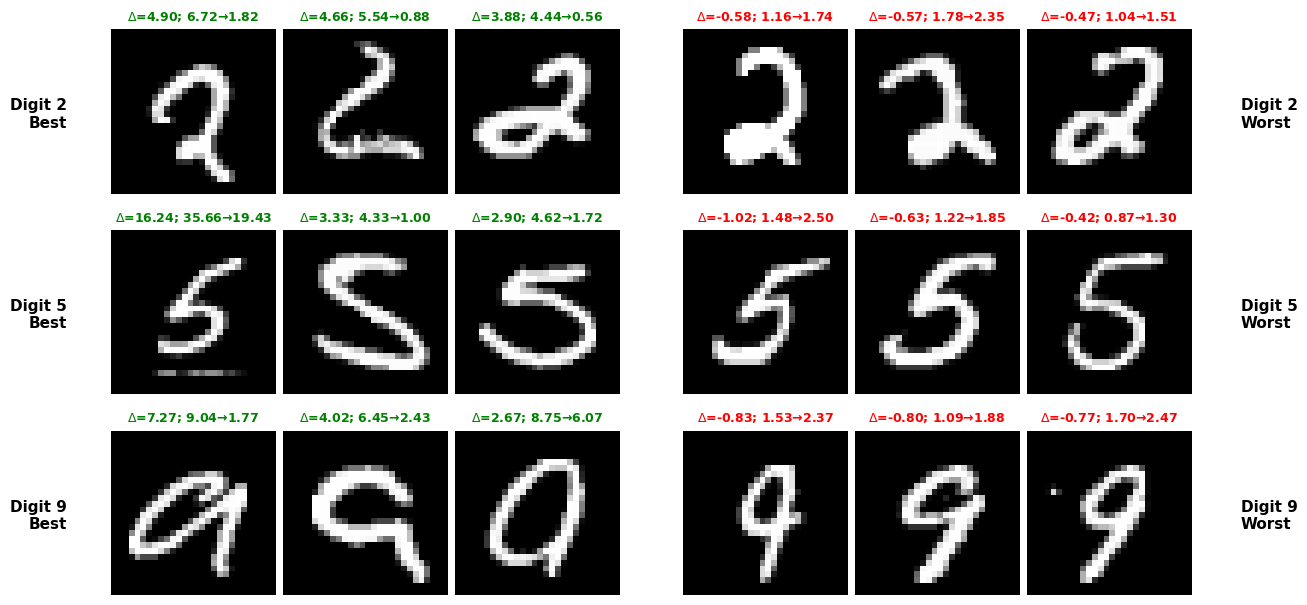

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from matplotlib.gridspec import GridSpec

df = pd.read_csv("results/experiment2_same_decoders/experiment2_results.csv")

with open("datasets/mnist.pkl", "rb") as f:
    mnist = pickle.load(f, encoding="latin1")

    mnist_data = np.concatenate((mnist[0][0], mnist[1][0]))
    mnist_labels = np.concatenate((mnist[0][1], mnist[1][1]))

# first i need to find be best/worst digits. then select the hardest and easiest 1 or 2
digit_difficulty = []
for digit in range(10):
    digit_data = df[(df["digit_label"] == digit) & (df["model"] == "standard")]
    mean_gamor = digit_data["G_amor"].mean()
    digit_difficulty.append((digit, mean_gamor))

digit_difficulty_sorted = sorted(digit_difficulty, key=lambda x: x[1], reverse=True)
selected_digits = [
    digit_difficulty_sorted[0][0],  # harded
    digit_difficulty_sorted[1][0],
    digit_difficulty_sorted[-2][0],
]
# NOTE also had the easiest but dropped it for the paper as it did not show much
print(selected_digits)


n_extreme = 3
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(
    3,
    2 * n_extreme + 1,
    figure=fig,
    hspace=0.15,
    wspace=0.05,
    top=0.98,
    bottom=0.02,
    left=0.08,
    right=0.98,
    width_ratios=[1, 1, 1, 0.3, 1, 1, 1],
)  # small gap for alignments

for row_idx, digit in enumerate(selected_digits):
    std_data = df[(df["digit_label"] == digit) & (df["model"] == "standard")].copy()
    large_data = df[(df["digit_label"] == digit) & (df["model"] == "large")].copy()

    merged = std_data.merge(large_data, on="datapoint_idx", suffixes=("_std", "_large"))
    merged["improvement"] = merged["G_amor_std"] - merged["G_amor_large"]

    best_improvements = merged.nlargest(n_extreme, "improvement")
    worst_improvements = merged.nsmallest(n_extreme, "improvement")

    for i, (_, row) in enumerate(best_improvements.iterrows()):
        ax = fig.add_subplot(gs[row_idx, i])
        idx = int(row["datapoint_idx"])
        improvement = row["improvement"]
        g_amor_std = row["G_amor_std"]
        g_amor_large = row["G_amor_large"]

        img = mnist_data[idx].reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"$\\Delta$={improvement:.2f}; {g_amor_std:.2f}→{g_amor_large:.2f}",
            fontsize=9,
            color="green",
            fontweight="bold",
        )

        if i == 0:
            ax.text(
                -8,
                14,
                f"Digit {digit}\nBest",
                fontsize=11,
                fontweight="bold",
                ha="right",
                va="center",
            )

    for i, (_, row) in enumerate(worst_improvements.iterrows()):
        ax = fig.add_subplot(gs[row_idx, i + 4])
        idx = int(row["datapoint_idx"])
        improvement = row["improvement"]
        g_amor_std = row["G_amor_std"]
        g_amor_large = row["G_amor_large"]

        img = mnist_data[idx].reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"$\\Delta$={improvement:.2f}; {g_amor_std:.2f}→{g_amor_large:.2f}",
            fontsize=9,
            color="red",
            fontweight="bold",
        )

        if i == n_extreme - 1:
            ax.text(
                36,
                14,
                f"Digit {digit}\nWorst",
                fontsize=11,
                fontweight="bold",
                ha="left",
                va="center",
            )

plt.savefig("figures/exp2_extreme_cases.pdf", bbox_inches="tight", dpi=300)
plt.show()